# FUNCTIONS

Rex Thompson  
DATA 558 - Spring 2017  
6/9/2017

### Initial setup

In [1]:
# THINGS NEEDED FOR COORDDESCENT.PY TO RUN
import copy
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt




# THINGS NOT NEEDED IN COORDDESCENT.PY FILE ITSELF
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Complete (but not yet polished with comments, docstrings, etc)

In [2]:
def compute_obj(beta, X, y, lam, alpha):
    obj = (1/len(y))*np.sum((y - X.dot(beta))**2) + lam*(alpha*np.sum(np.abs(beta)) + (1-alpha)*beta.dot(beta))
    return obj

In [3]:
def compute_beta_j_new(beta, X, y, lam, alpha, j, match_skl=False):
    x_j = X[:,j]
    beta_dropJ = np.delete(beta, j)
    X_dropJ = np.delete(X, j, 1)
    n = len(y)
    
    if match_skl:
        num = 1
    else:
        num = 2
        
    a_j = (num/n)*(x_j.dot(x_j) + lam*n*(1-alpha))
    c_j = (num/n)*x_j.dot(y - X_dropJ.dot(beta_dropJ))
    
    if c_j < -lam*alpha:
        return (c_j + lam*alpha)/a_j
    elif c_j > lam*alpha:
        return (c_j - lam*alpha)/a_j
    else:
        return 0

In [4]:
def coorddescent(beta_init, X, y, lam, alpha, tol=0, max_iter=1000, desc_type="cyclic", match_skl=False):
    
    beta = copy.deepcopy(beta_init)
    stepCoords = copy.deepcopy([beta])
    p = len(beta)
    it = 0  # initialize iteration counter
    dist = copy.deepcopy(tol)
    max_iter = max_iter*p
    
    while dist >= tol and it < max_iter:
        
        # pick a coordinate
        if desc_type == "cyclic":
            j = np.mod(it, p)
        elif desc_type == "random":
            j = np.random.randint(p)
        else:
            raise Exception("Invalid descent type: " + desc_type)
        
        # find new beta_j by minimizing F(beta) w.r.t. beta_j; other coords stay the same
        beta[j] = compute_beta_j_new(beta, X, y, lam, alpha, j, match_skl)
        stepCoords.append(np.array(beta))
        
        # compute distance from last attempt for convergence threshold check
        if np.mod(it, p) == p-1:
            last_beta = stepCoords[-p-1]
            dist = np.sqrt(sum((beta - last_beta)**2))
        it += 1
        
    return stepCoords

In [5]:
def cross_validate_coord_descent(X, y, lambdas, folds=3, alpha=.9, max_iter=1000, random_seed=None, match_skl=False):
    
    if isinstance(random_seed, int)
        np.random.seed(random_seed)
    else:
        pass
    
    n, p = X.shape
    all_MSEs = np.empty((0, len(lambdas)))
    
    idxs = (list(range(folds)) * (n//folds+1))[0:n]
    np.random.shuffle(idxs)
    idxs = np.array(idxs)
    
    for i in range(folds):
        X_train_CV = X[idxs!=i,:]
        X_test_CV = X[idxs==i,:]
        y_train_CV = y[idxs!=i]
        y_test_CV = y[idxs==i]
        MSEs_mine = []
        for lam in lambdas:
            betas_cyclic = coorddescent(np.zeros(p), X_train_CV, y_train_CV, lam, alpha, tol=-1, max_iter=max_iter, match_skl=match_skl)
            y_pred = np.dot(X_test_CV, betas_cyclic[-1])
            MSEs_mine.append(mean_squared_error(y_test_CV, y_pred))
        all_MSEs = np.vstack((all_MSEs, MSEs_mine))
    
    return all_MSEs

In [23]:
def plot_MSEs(lambdas, all_MSEs):
    all_MSEs_mean = np.mean(all_MSEs, axis=0)
    for i in range(len(all_MSEs)):
        plt.plot(np.log(lambdas), all_MSEs[i], '--', linewidth=.8);
    plt.plot(np.log(lambdas), all_MSEs_mean, 'black', linewidth=2);
    plt.xlabel('log' + r'($\lambda)$')
    plt.ylabel('MSE');

### TEMP DATA FOR TESTING

In [6]:
# data import and initial cleanup
# hitters = pd.read_csv('./data/Hitters.csv', sep=',', header=0)
hitters = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv', sep=',', header=0)
hitters = hitters.dropna()

# split out predictors and response
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

# Encode the variables League, Division, and NewLeague
X = pd.get_dummies(X, drop_first=True)

# convert to numpy arrays
X = np.array(X)
y = np.array(y)

# TEMP
X = (X-np.mean(X, axis=0)) / np.std(X, axis=0)
y = (y-np.mean(y)) / np.std(y)

In [7]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# scale and center predictors
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test);

In [8]:
# TEMP FOR TESTING
# X = copy.deepcopy(x)
n, p = X.shape
beta = np.zeros(p) + 0.75
lam = 0.44
alpha = .9

I now assign the arguments and run this function. I am using 5 folds, with initial splits randomly assigned (but roughly equal in size). The results are plotted below; the dashed lines are the MSEs at various $\lambda$ values for each individual fold, and the thick black line is the mean of the MSEs for each $\lambda$ value across all the folds.

In [10]:
max_iter = 1000
lambdas = np.array([10**k for k in range(-5, 1)])
np.random.seed(5)
all_MSEs = cross_validate_coord_descent(X, y, lambdas, 5, 0.9, max_iter)
all_MSEs_mean = np.mean(all_MSEs, axis=0)

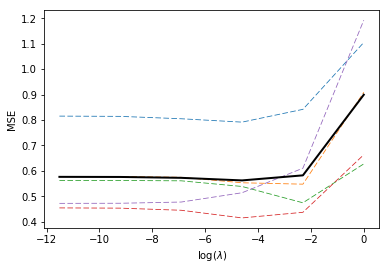

In [11]:
for i in range(len(all_MSEs)):
    plt.plot(np.log(lambdas), all_MSEs[i], '--', linewidth=.8);
plt.plot(np.log(lambdas), all_MSEs_mean, 'black', linewidth=2);
plt.xlabel('log' + r'($\lambda)$')
plt.ylabel('MSE');

In [12]:
best_lam = lambdas[np.argmin(all_MSEs_mean)]
print("Optimal lambda = ", best_lam)

Optimal lambda =  0.01


### Bullet 9

I now run both my cyclic and random coordinate descent functions on the Hitters dataset using the optimal $\lambda$ value I found through cross-validation in the previous bullet (i.e. 0.01).

In [ ]:
np.random.seed(50)
betas_cyclic = coorddescent(np.zeros(p), X, y, best_lam, 0.9, -1, max_iter, desc_type="cyclic")
betas_random = coorddescent(np.zeros(p), X, y, best_lam, 0.9, -1, max_iter, desc_type="random")
objVals_cyclic = [ compute_obj(b, X, y, best_lam, 0.9) for b in betas_cyclic ]
objVals_random = [ compute_obj(b, X, y, best_lam, 0.9) for b in betas_random ]

In [ ]:
newIter = [i/p for i in range(len(objVals_cyclic))]
fig = plt.figure(figsize=[14,4])
ax1 = fig.add_subplot(121)
ax1.plot(newIter, objVals_cyclic)
ax1.plot(newIter, objVals_random)
plt.xlabel('Iteration Counter')
plt.ylabel('Objective Function Value');
ax1.legend(['cyclic','random'])
ax2 = fig.add_subplot(122)
ax2.plot(newIter[0:19*14], objVals_cyclic[0:19*14]);
ax2.plot(newIter[0:19*14], objVals_random[0:19*14]);
plt.xlabel('Iteration Counter')
plt.ylabel('Objective Function Value');
ax2.legend(['cyclic','random']);

The plots above show the objective function values for the $\beta$ values found using my cyclic and random coordinate descent algorithms. As shown, both algorithms' objective function values quickly converge towards a final solution. The plot on the right zooms in on the elbow to show that the random coordinate descent algorithm approaches the final solution more quickly than the cyclic coordinate descent algorithm in this case. However, note that I experimented with several different seeds and in quite a few cases observed cyclic algorithm results that converged more rapidly than those from the random descent algorithm!

The plot below shows the coefficient estimates for both of my approaches (blue circles and red crosses for cyclic and random descent algorithms, respectively), along with the results from scikit-learn's ElasticNetCV function (orange circles). My results are essentially identical to one another, with each red cross sitting right on top of a blue circle below. My algorithms' coefficients, while not an exact match, also line up quite well with those found using scikit-learn's ElasticNetCV function. Most coefficients are identical or very close; only a few appear to be off by a little bit (it appears the more extreme coefficients are worst). Small differences are not a surprise since the scikit-learn function uses a slightly different objective function than the one I used for my cyclic and random coordinate descent algorithms (see below for more on this). Additionally, the scikit-learn function uses a $\lambda$ value found through its own cross-validation, and it is not necessarilty the same as the $\lambda$ value I used in my functions.

In [ ]:
en = ElasticNetCV(l1_ratio=0.9)
en.fit(X, y)
en.coef_
skl_alpha = en.alpha_
plt.plot(betas_cyclic[-1], '.', color='blue', ms=12)
plt.plot(betas_random[-1], '+', color='red', ms=10)
plt.plot(en.coef_, '.', color='orange');
plt.legend(['cyclic','random','sklearn'], loc=1);

For reference, below are the actual coefficients for both of my algorithms along with those from the ElasticNetCV function. As shown, the coefficients match up quite well; the magnitudes are very close for most coefficients, and with only one exception they both identified the same zero- and non-zero coefficients.

In [ ]:
print("my cyclic:\n", betas_cyclic[-1])
print("my random:\n", betas_random[-1])
print("sciklearn:\n", en.coef_)

As a check on my own equations, I derived the formulas to perform coordinate descent based on the objective function in the scikit-learn ElasticNet function. The solution was almost identical to what I had already derived, with the exception of the factor of 2 in front of the $c_j$ and $w_j$ terms. I updated my `compute_beta_j_new` function as well as my `cycliccoorddescent` and `randcoorddescent` functions to check them against scikit-learn - see below.

I performed calculations similar to above (except using the optimal $\lambda$ found using scikit-learn's ElasticNetCV function above for all three approaches), and compared the results:

In [ ]:
betas_cyclic_new = coorddescent(np.zeros(p), X, y, skl_alpha, 0.9, tol=-1, desc_type="cyclic", match_skl=True)
betas_random_new = coorddescent(np.zeros(p), X, y, skl_alpha, 0.9, tol=-1, desc_type="random", match_skl=True)

# X_df = pd.DataFrame(X)
# betas_cyclic_new = cycliccoorddescent_sklearn(np.zeros(p), X_df, y, skl_alpha, 0.9, max_iter)
# betas_random_new = randcoorddescent_sklearn(np.zeros(p), X_df, y, skl_alpha, 0.9, max_iter)

en_new = ElasticNet(l1_ratio=0.9, alpha=skl_alpha)
en_new.fit(X, y)
plt.plot(betas_cyclic_new[-1], '.', color='blue', ms=12)
plt.plot(betas_random_new[-1], '+', color='red', ms=10)
plt.plot(en.coef_, '.', color='orange');
plt.legend(['cyclic','random','sklearn'], loc=1);

As shown, the points sit right on top of one another for every coefficient, indicating that the three algorithms are essentially identical. This gives me high confidence that I derived my original equations above correctly!

For reference, here are the coefficients for the three approaches:

In [ ]:
print("my cyclic (updated):\n", betas_cyclic_new[-1])
print("my random (updated):\n", betas_random_new[-1])
print("sciklearn:\n", en.coef_)

### Bullet 10

For warm-start, I first find $\lambda_0$ by calculating the max of the absolute value of the inner products of $x_j$ and $y$ for all $j$, divided by $n$. I multiply by 2 compared to the equation in the reference text due to the different objective functions between the sources.

In [ ]:
2*max(abs(np.inner(X.T, y))/n)

This tells me that the Lasso coefficients will all converge to zero for any $\lambda$ greater than ~1.134, so I select $\lambda$ values on a log scale decreasing from the smallest power of 10 that is larger than this value (i.e. $10^1 = 10$), down towards zero.

In [ ]:
lambdas = np.array([10**k for k in range(-5, 2)])[::-1]
lambdas

To really take advantage of the warm-start approach, I need to build in a thresholding cutoff into my coordinate descent algorithm (otherwise my function will still run the exact same number of iterations). My original function stopped after a maximum number of iterations only; I now enable it to stop iterating once the norm of the distance between $\beta$ values in adjacent steps (through all coordinates) falls below some given threshold.

In [ ]:
start_time = time.time()

betas_warm_start = np.empty((0,p))
betas = np.zeros(p)
max_iter = 1000*p
for lam in lambdas:
    betas = cycliccoorddescent(betas, X, y, lam, 0.9, 0.001, max_iter)[-1]
    betas_warm_start = np.vstack((betas_warm_start, betas))

print("--- %s seconds ---" % (time.time() - start_time))

The plot below shows the $\beta$ values for each $\lambda_{\ell}$ (note that $\lambda$ decreases logarithmically from left to right). As expected, all the coefficients begin at 0 for $\lambda_0$, and more non-zero coefficients come into the picture as $\lambda$ decreases.

Also note that this function ran in ~14 seconds.

In [ ]:
plt.plot(betas_warm_start);
plt.xlabel("$\ell$");
plt.ylabel(r'$\beta$' + " values");
plt.title("Warm Start Implementation");

I now run the same updated coordinate descent algorithm (i.e. with distance thresholding), but this time **_without_** the warm-start procedure, to see whether this procedure actually sped things up.

In [ ]:
start_time = time.time()

betas_cold_start = np.empty((0,p))
for lam in lambdas:
    betas2 = cycliccoorddescent(np.zeros(p), X, y, lam, 0.9, 0.001, max_iter)[-1]
    betas_cold_start = np.vstack((betas_cold_start, betas2))

print("--- %s seconds ---" % (time.time() - start_time))

Sure enough, it looks like it took about 2-3 times longer to run without the Warm Start, even with all other settings being equal. Thus, it appears the Warm Start really worked!

The plot below shows the coefficients from the Cold Start approach. Again, the general pattern is what we would expect and at a glance the coefficients appear to be a pretty close match to those found using the Warm Start approach.

In [ ]:
plt.plot(betas_cold_start);
plt.xlabel("$\ell$");
plt.ylabel(r'$\beta$' + " values");
plt.title("Cold Start Implementation");

For the sake of completeness I display the differences in the coefficients between the two approaches below. They are spot-on for the first three $\lambda$ values but they start to diverge slightly after that. Presumably, increasing the iteration count and/or reducing the convergence threshold would bring them into closer agreement for the smaller $\lambda$ values.

In [ ]:
plt.plot(betas_warm_start - betas_cold_start);
plt.xlabel("$\ell$");
plt.ylabel(r'$\beta$' + " values");
plt.title("Warm Start Minus Cold Start");

## MISC CODE

In [ ]:

# # center and standardize predictors; center response
# x = (x-np.mean(x)) / np.std(x)
# y = (y-np.mean(y)) / np.std(y)

# n, p = x.shape